<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch5_9~10_pg_342~375_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이썬 머신러닝 완벽가이드 ch5.9 ~ 10 pg. 342~375 필사
#### 2023.05.26. - 2129014 박지현

## CH05.09. 회귀 실습 - 자전거 대여 수요 예측

캐글의 자전거 대여 수요(Bike Sharing Demand) 예측 경연에서 사용된 학습 데이터 세트 이용해 선형 회귀와 트리 기반 회귀 비교하기

- 테스트 데이터 살펴보기: 2011.01. ~ 2012.12.까지의 날짜/시간, 기온, 습도, 풍속 등의 정보 기반 1시간 간격 동안의 자전거 횟수 기재된 데이터
 - 결정값 : 'count' = '대여 횟수'

 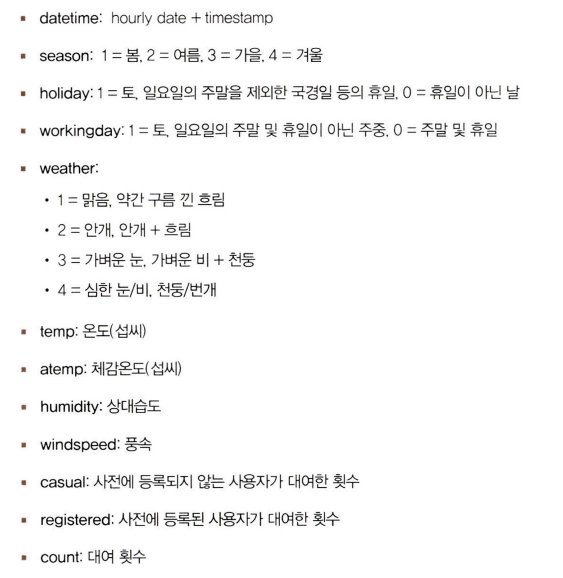

### 데이터 클렌징 및 가공

- bike_train.csv 데이터 세트를 이용해 모델 학습 후 대여 횟수(count) 예측하기

1. 데이터 세트 DataFrame으로 로드해 대략적으로 데이터 확인하기

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


> 결과 : 해당 데이터셋 : 10886개의 레코드, 12개의 칼럼

2. 데이터 칼럼의 타입 살펴보기

In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


> 결과 : Null 데이터 없음
    대부분의 칼럼 : int or float 숫자형
    Datetime 칼럼 : 년-월-일 시:분:초 문자 형식 > 이에 대한 가공 필요

3. 'datetime'을 년,월,일,시간 4개의 속성으로 분리하기 - 문자열을 'datetime'으로 변환하여 년,월,일,시간 칼럼 추출
- 판다스 : 문자열 datetime으로 변환하는 apply(pd.to_datetime) 메서드 제공

In [ ]:
# 문자열을 datetime 타입으로 변경.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


4. 'datetime' 칼럼 삭제하기 + 'casual' 칼럼, 'registered' 칼럼 삭제하기

- 'casual' 칼럼 : 사전에 등록하지 않은 사용자의 자전거 대여 횟수
- 'registered' 칼럼 : 사전에 등록한 사용자의 대여 횟수
>'casual' + 'registered' = 'count' (따로 필요 X) + 상관도가 높아 예측 저해 가능 > 두 칼럼 삭제하기

In [ ]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

5. RMSLE(Root Mean Square Log Error, 오류 값의 로그에 대한 RMSE), MAE, RMSE를 수행하는 성능 평가 함수 만들기
- 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능 측정하기 위한 함수
- 캐글 : 사이킷런이 제공하지 않는 RMSLE로 성능 평가 > 함수 직접 만들어야 함

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
# log1p = 1 + log() > 오버플로/언더플로 문제 해결해줌 + 넘파이의 expm1() 함수로 쉽게 원래 스케일로 복원 가능
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [ ]:
# rmsle 구할 때 넘파이의 log()함수 / 사이킷런의 mean_squared_log_error() 이용하지 않는 이유
# 데이터 값 크기에 따라 오버플로/언더플로 오류 발생하기 쉽기 때문

# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽습니다.
# def rmsle(y, pred):
    # msle = mean_squared_log_error(y, pred)
    # rmsle = np.sqrt(mse)
    # return rmle

### 로그 변환, 피처 인코딩화 모델 학습/예측/평가

- 회귀 모델 적용하면서 1. 결과값이 정규 분포로 되어 있는지, 2. 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처 인코딩했는지 두 가지 사항 확인 필요


1. 사이킷런의 LinearRegression 객체를 이용해 회귀 예측하기

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3,
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


> 결과 : 예측 오류로서 비교적 큰 값이 나옴

2. 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인하기

In [ ]:
def get_top_error_data(y_rest, pred, n_tops = 5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])

    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력.
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


> 결과 : 상위 5개 오류 값 : 546 ~ 568 > 예측 오류 꽤 큼
 - 회귀에서 큰 예측 오류 발생 시 가장 먼저 살펴볼 것 : **Target 값의 분포가 왜곡된 형태를 이루고 있는가?**
    - Target 값 분포 : 정규 분포 형태가 이상적
    - 그렇지 않을 경우, 회귀 예측 성능이 저하도는 경우 발생 쉬움

- 자전거 대여 모델의 Target 값인 'count' 칼럼이 왜곡된 형태가 아닌지 = 정규 분포를 이루는지 확인해보기

<Axes: >

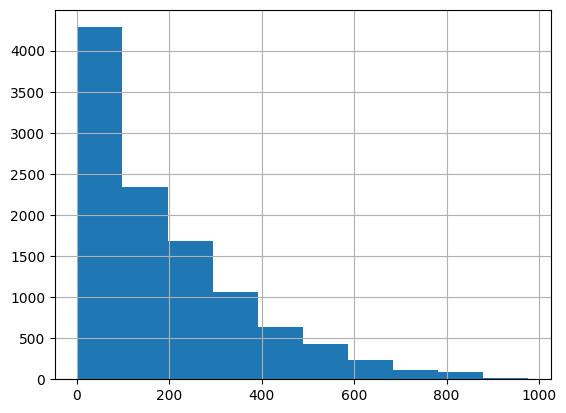

In [ ]:
y_target.hist()

> 결과 : 'count' 칼럼 : 정규 분포 X, 0 ~ 200 사이 왜곡되어 있음
 - 로그 적용 > 변환해 정규 분포 형태로 바꿀 수 O

- 넘파이의 log1p()를 적용한 'count' 값의 분포 확인하기
 - 변환된 Target 값 기반 학습, 예측한 값 expm1() 함수 적용해 원래 scale 값으로 원상 복구하기

<Axes: >

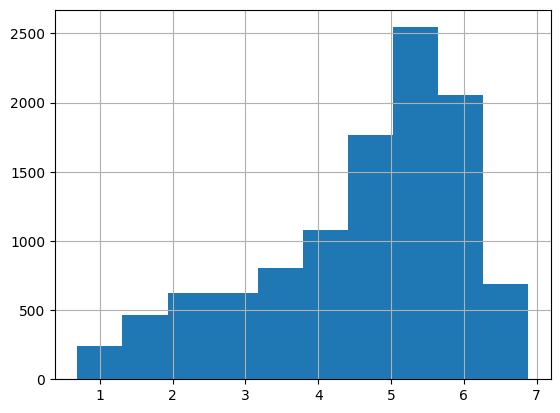

In [ ]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

> 결과 : 정규 분포 형태는 아니지만 전보다 왜곡 정도가 많이 향상되었음

- 로그 변환한 것을 이용해 다시 학습한 후 평가 수행하기

In [ ]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3,
                                                    random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


> 결과 : RMSLE 오류 줄어듬, But RMSE는 오히려 더 늘어남

- RMSE 늘어난 이유를 찾기 위해 각 피처의 회귀 계수 값을 시각화해보기

<Axes: >

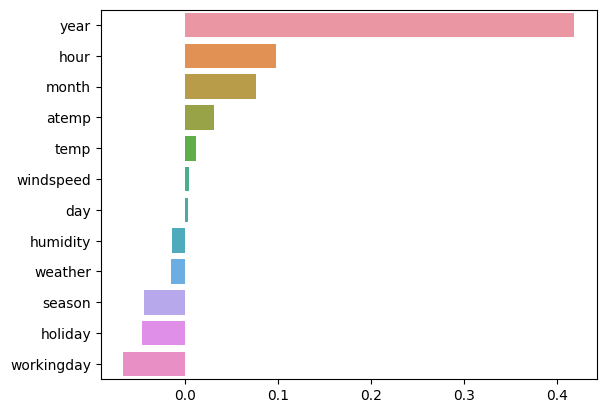

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

> 결과 : 'Year' 피처 회귀 계수 값이 독보적으로 큰 값을 가지고 있음
 - 'Year'=2011,2012처럼 아주 큰 값으로 되어 있는 숫자형 카테고리 값을 선형 회귀에 사용할 경우, 회귀 계수 연산할 때 이 숫자형 값에 크게 영향 받는 경우 발생 가은
 - 따라서, 상식적으로 year에 따라 자전거 대여 횟수가 크게 영향을 받지 않는다는 것과 상충되는 회귀 계수가 나온 것

**선형 회귀에는 이러한 피처 인코딩에 원-핫 인코딩 적용해 변환해야 함!**

- 'year' 칼럼을 비롯해 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weathre' 칼럼 모두 원핫 인코딩 후 다시 예측 성능 확인해보기
 - 판다스의 get_dummies() 이용

In [ ]:
# 'year', 'month', 'day', 'hour' 등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday',
                                                     'workingday', 'season', 'weather'])

- 모델과 학습/테스트 데이터 세트 입력하면 성능 평가 수치를 반환하는 get_model_predict() 함수 만들기
 - 사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능 확인하기 위한 함수

In [ ]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


> 결과 : 원-핫 인코딩 후 선형 회귀의 예측 성능 많이 향상됨

- 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처 상위 20개를 추출해 다시 시각화하기

<Axes: >

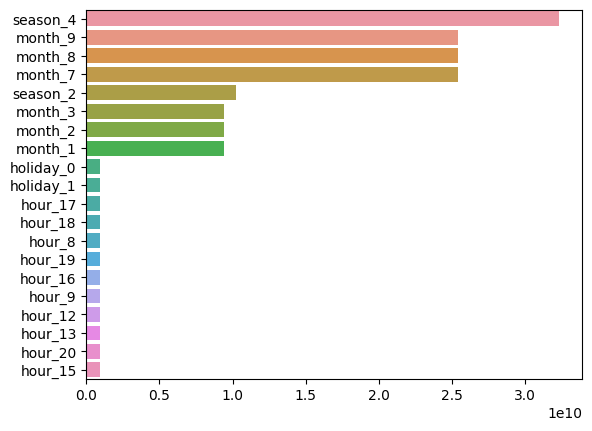

In [ ]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

> 결과 : 시즌=계절 관련 피처들, 월 관련 피처들, workingday 관련 피처들, hour 관련 피처들의 회귀 계수 높은 것 확인 가은

**선형 회귀 수행 시에는 피처를 어떻게 인코딩하는가가 선능에 큰 영향을 미칠 수 있다.**

- 회귀 트리를 이용해 회귀 예측 수행하기
 - Target값의 로그 변환된 값 & 원-핫 인코딩된 피처 데이터 세트 이용
 - 랜덤 포레스트, GBM, XGBoost(>학습/테스트 데이터: DataFrame의 value 속성을 이용해 ndarray로 변환하기), LightGBM을 순자적으로 성능 평가하기

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model, X_train.values, X_test.values, y_train.values,
                      y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.288, MAE: 31.101
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.371, MAE: 32.753
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


> 결과 : 앞의 선형 회귀 모델보다 회귀 예측 성능 개선됨

But, 회귀 트리가 선형 회귀보다 더 나은 성능 가진다는 의미는 아님 - 데이터 세트의 유형에 따라 결과 얼마든지 달라질 수 있음

## CH05.10. 회귀 실습 - 캐글 주택 가격 : 고급 회귀 기법

캐글의 캐글 주택 가격 : 고급 회귀 기법(Housing Prices: Advanced Regression Techniques) 데이터 세트 이용해 회귀 분석 더 심층적으로 학습하기

**데이터**
- 79개의 변수
- 미국 아이오과 주의 에임스(Ames) 지방의 주택 가격 정보를 가지고 있음
- 성능 평가 : 위와 동일한 RMSLE 기반 성능 평가
    - 가격이 비싼 주택일수록, 예측 결과 오류가 전체 오류에 미치는 비중 큼 > 오류 값을 로그 변환한 RMSLE 이용
- Target 값 : 맨 마지막 칼럼인 SalePrice

### 데이터 사전 처리(Preprocessing)

1. 필요한 모듈과 데이터 로딩, 개략적으로 데이터 확인하기
- 데이터 가공 많이 수행 예정 > 원본 파일 보관, 복사 후 데이터 가공하기

In [ ]:
from io import IncrementalNewlineDecoder
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


2. 데이터 세트의 전체 크기와 칼럼의 타입, Null이 있는 칼럼과 그 건수를 내림차순으로 출력하기

In [ ]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n ', isnull_series[isnull_series >0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


**데이터 세트**
- 1460개의 레코드, 81개의 피처로 구성됨
- 피처의 타입 : 숫자형 + 문자형
    - Target 제외한 80개 피처 중 43개: 문자형 / 나머지: 숫자형
- 전체 1480개의 데이터 중 'PollQC', 'MiscFeature', 'Alley', 'Fence' : 100개가 넘는 데이터가 Null > Null 값 너무 많은 피처 드롭하기

3. 회귀 모델 적용하기 전, 타깃 값의 분포도가 정규 분포인지 확인하기

<Axes: title={'center': 'Original Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

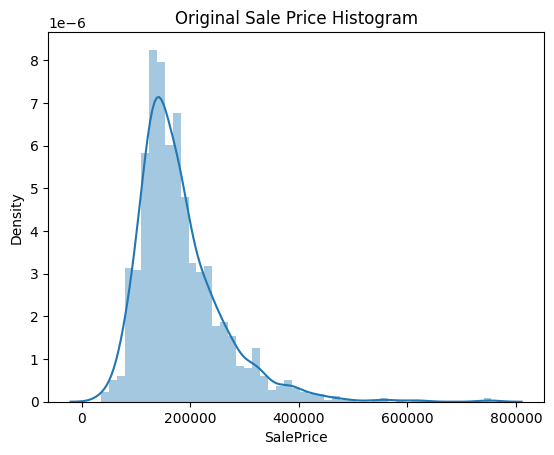

In [ ]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

> 결과 : 타깃 데이터 값의 분포 : 중심에서 왼쪽으로 치우친 형태 > 정규 분포에서 벗어나 있음


4. Target 칼럼에 로그 변환(Log Transformation) 적용하고 분포도 살펴보기
- 정규 분포가 아닌 Target 결괏값을 정규 분포 형태로 변환하기 위함
- 넘파이의 log1p()로 로그 변환한 결괏값 기반 학습 > 예측 시 결괏값 expm1()으로 추후 환원하기

<Axes: title={'center': 'Log Transformed Sale Price Histogram'}, xlabel='SalePrice', ylabel='Density'>

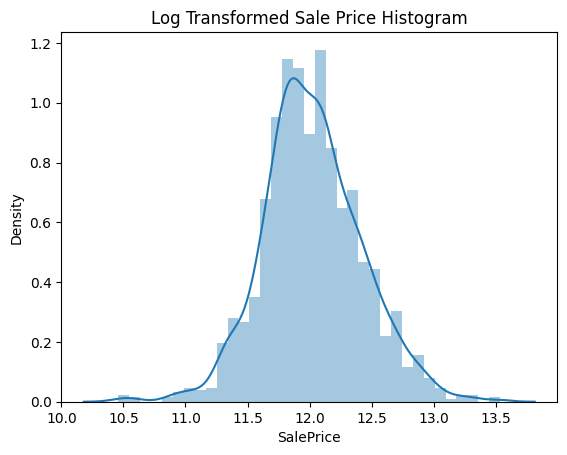

In [ ]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

> 결과 : 'SalePrice'를 로그 변환하여 정규 분포 형태로 결괏값 분포함을 확인할 수 있었음

5. 로그 변환 및 Null 피처의 전처리 수행하기
- 로그 변환 : 위에서와 같은 방법
- Null 피처의 전처리 : Null 값이 많은 피처인 'PollQC', 'MiscFeature', 'Alley', 'Fence' 삭제하기 + 단순 식별자 'Id' 삭제하기 + 'LotFrontage'(Null 개수 : 259개)을 비롯한 숫자형 피처들의 Null값 평균값으로 대체
    - mean() 메서드 이용 : 자동으로 숫자형 칼럼만 추출해 칼럼별 평균값 Series 객체로 반환함
    - DataFrame.fillna(DataFrame.mean()) :결과적으로 Null 값인 숫자형 피처만 평균값으로 대체해줌

In [ ]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1,
             inplace=True)
# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print("## Null 피처의 Type :\n", house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


> 결과 : 문자형 피처를 제외하고는 Null 값 없음


6. 문자형 피처 : 모두 원-핫 인코딩으로 변환시키고, 칼럼의 증가를 확인하기
- 판다스의 get_dummies() 이용 : 자동으로 분자열 피처 원-핫 인코딩 + Null 값 'None'으로 대체해줌 > 별도의 Null 값 대체하는 로직 필요 X 

In [ ]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 271)
## Null 피처의 Type :
 Series([], dtype: object)


> 결과 
- 원-핫 인코딩 후 피처 75>272개로 증가 확인 가능
- Null 값 가진 피처 존재 X

### 선형 회귀 모델 학습/예측 평가
- 데이터 세트를 학습/테스트 데이터 세트로 분할해 사이킷런의 LinearRegression, Ridge, Lasso 이용해 선형 계열의 회귀 모델 만들기

1. 성능 평가 지표인 로그 변환된 RMSE 측정하는 함수 만들기
- 예측 평가 : RMSLE(=실제 값과 예측값의 오류 로그 변환 뒤 RMSE 적용) 
-But, 이미 타깃 값 'SalePrice' 로그 변환됨 > 로그 변환된 'SalePrice' 값 기반 예측값 = 원본 "SalePrice' 예측값의 로그 변환값
- 즉, 실제 값, 예측값 모두 실제의 로그 변환 값 > 예측 결과 오류에 RMSE만 적용 -> RMSLE 자동 측정됨

In [ ]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse=get_rmse(model)
        rmses.append(rmse)
    return rmses

> 결과 
- get_mse(model) : 단일 모델의 RMSE 값 반환
- get_rmses(models) : get_rmse()를 이용해 여러 모델의 RMSE 값 반환


2. 선형 회귀 모델 학습, 예측 평가하기

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                   random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154297, 0.12750846334053004, 0.17628250556471403]

> 결과
- 라쏘 회귀 : 회귀 성능이 타 회귀 방식보다 많이 떨어짐 > 최적 하이퍼 파라미터 튜닝 필요함 (alpha 하이퍼 파라미터 최적화)



3. 피처별 회귀 계수를 시각화해서, 모델별로 어떠한 피처의 회귀 계수로 구성되는지 확인하기

- 3.1. 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객게 반환하는 함수 만들기

In [ ]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

- 3.2. 생성한 함수 get_top_bottom_coef(model, n=10) 이용하여 모델별 회귀 계수를 시각화하기
 - 시각화를 위한 함수로 visualize_coefficient(models) 생성하기 - list 객체로 모델 입력받아 모델 별로 회귀 계수 상위 10개, 하위 10개를 추출해 가로 막대 그래프 형태로 출력하는 함수

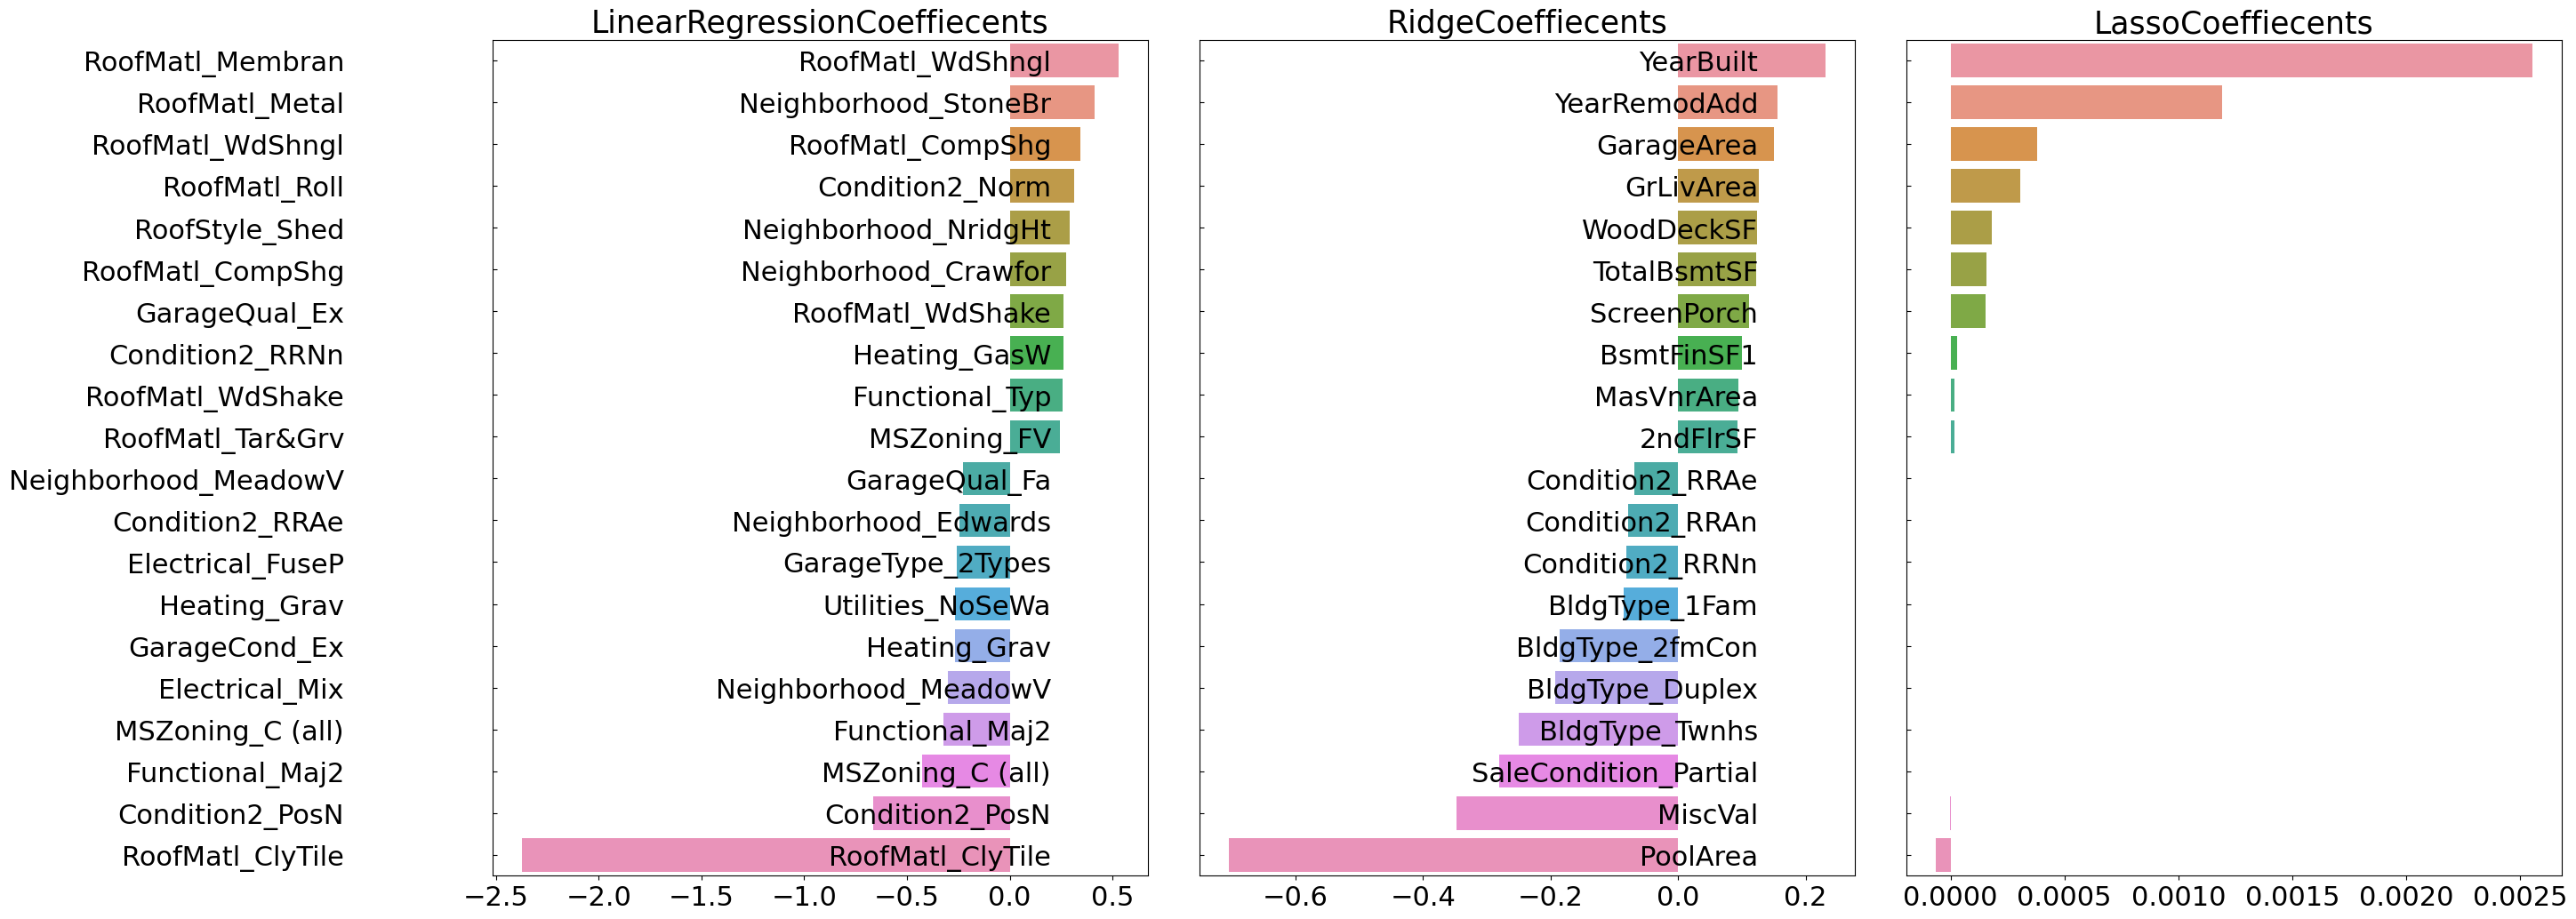

In [ ]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat =pd.concat([coef_high, coef_low])
        # ax, subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

> 결과 
- 모델별 회귀 계수 : OLS 기반 LinearRegression과 Ridge > 회귀 계수 유사한 형태
- 라쏘 : 다른 두 개의 모델과 다른 회귀 계수 형태
    - 전체적으로 회귀 계수 값 매우 작음 , 'YearBuilt'가 가장 크고 다른 피처의 회귀 계수 너무 작음


학습 데이터의 데이터 분할에 문제가 있어서 그런 것일까? 


4. 학습과 테스트 데이터 세트를 train_test_split()으로 분할하지 않고, 전체 데이터 세트인 X_features와 y_target을 5개의 교차 검증 폴드로 분할해 평균 RMSE 측정하기
 - 교차 검증을 위해 cross_val_score() 이용

In [ ]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                            scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))
 
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


> 5개의 폴드 세트로 학습한 후 평가 결과
- 라쏘 : OLS 모델, 릿지 모델보다 성능 떨어짐

5. 릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터 변화시키면서 최적 값 도출하기
- 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업 결과 표시하는 함수 print_best_params(model,params) 생성하기 + 릿지&라쏘 모델의 최적화 alpha 값 추출하기
    - 모델별로 최적화 하이퍼 파라미터 작업 반복적 수행을 돕기 위한 함수

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params,
                             scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, 
                                                            np.round(rmse,4), grid_model.best_params_))

ridge_params={ 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params={ 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


> 결과 
- 릿지 모델 : alpha = 12에서 최적 평균 RMSE : 0.1418
- 라쏘 모델 : alpha = 0.001에서 최적 평균 RMSE : 0.142 > alpha 값 최적화 이후 예측 성능 많이 좋아짐



6. 선형 모델에 최적 alpha 값을 설정한 뒤, train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고, 모델별 회귀 계수 시각화하기

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


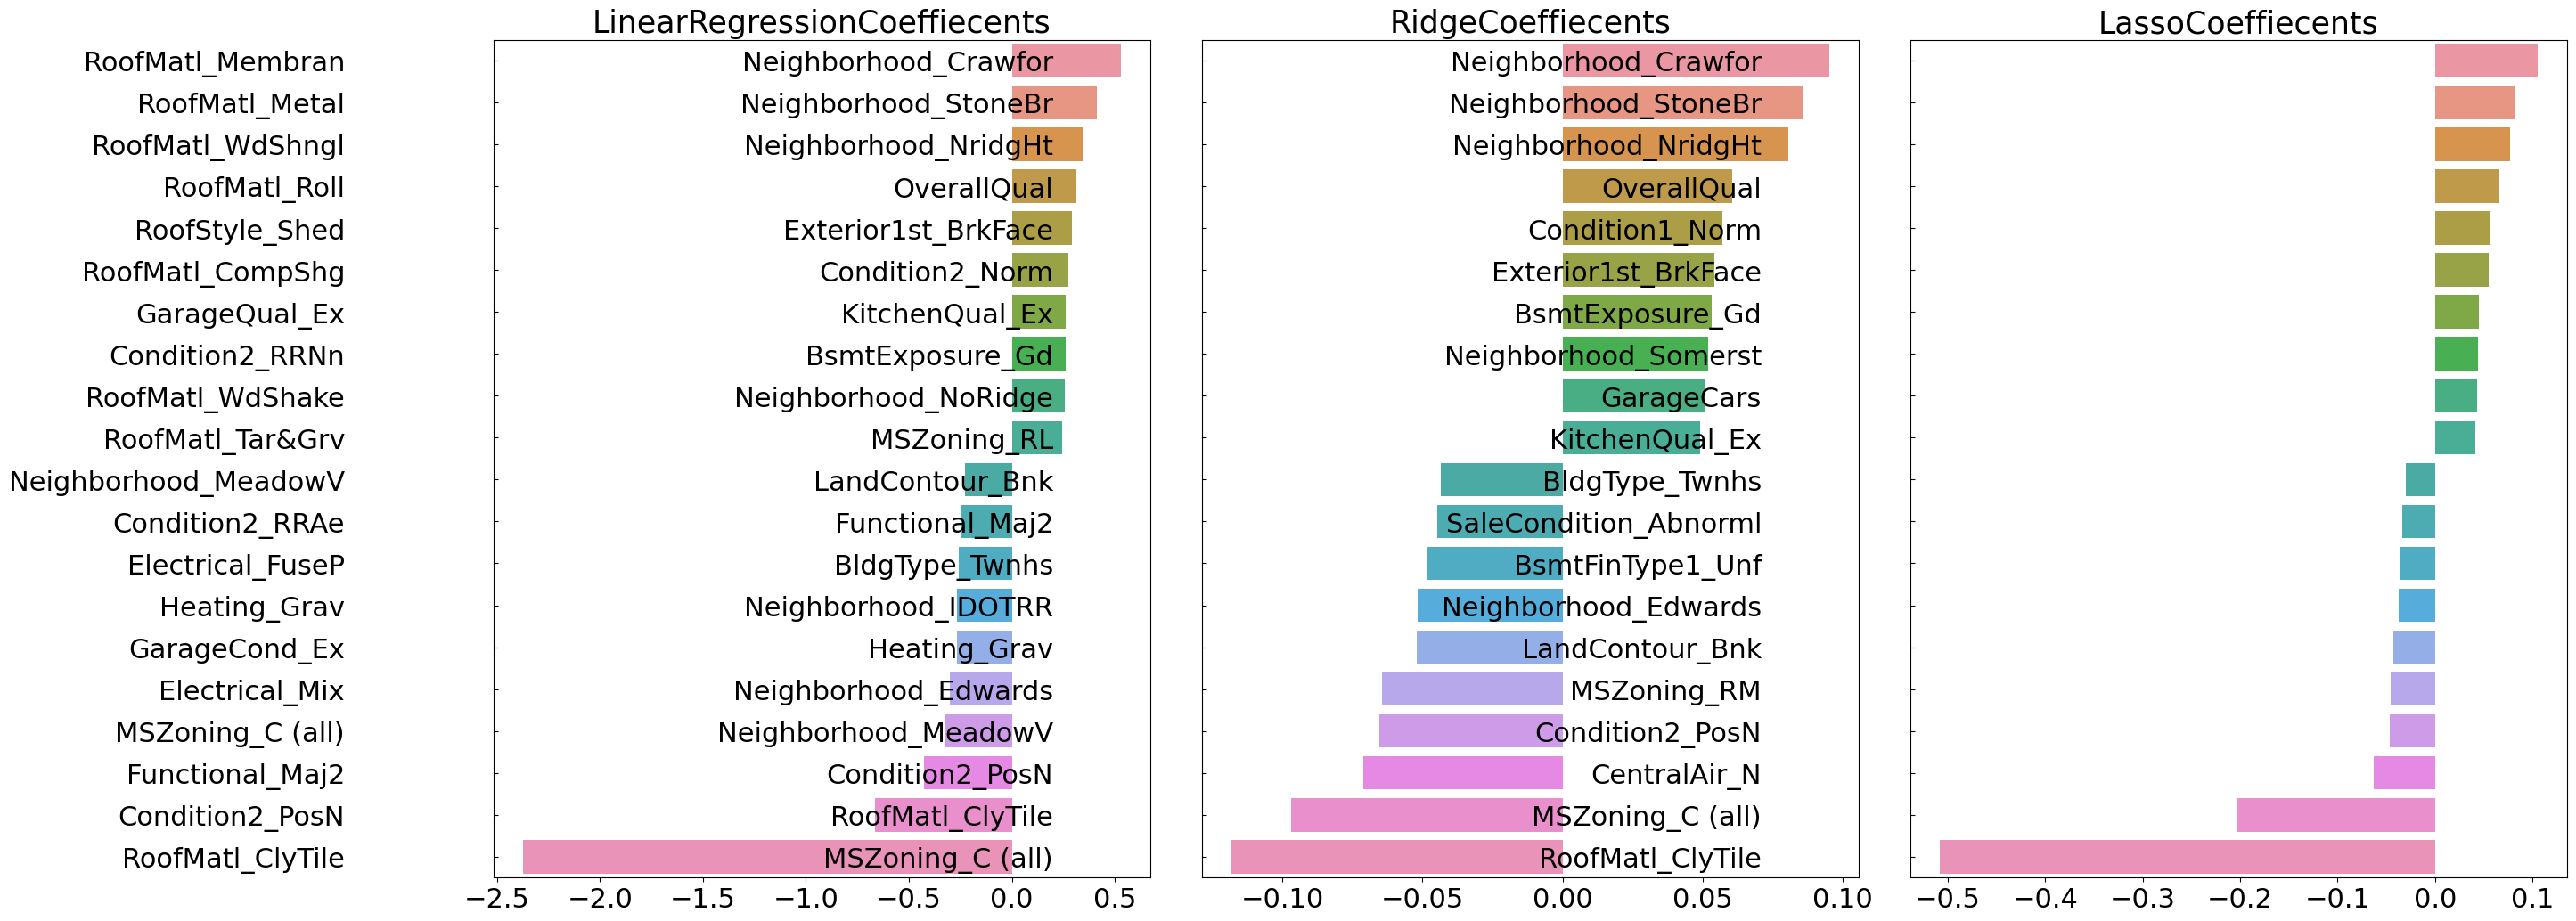

In [ ]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

> alpha 값 최적화 후 결과 
- 테스트 데이터 세트의 예측 성능이 더 좋아짐
- 모델별 회귀 계수 많이 달라짐
    - 특히, 릿지와 라쏘 모델에서 비슷한 회귀 계수가 높음
    - But, 라쏘 모델 : 릿지 모델에 비해 동일한 피처라도 회귀 계수 값 상당히 작음 


**데이터 세트 추가적으로 가공해서 모델 튜닝 좀 더 진행하기**

1. 피처 데이터 세트의 데이터 분포도
2. 이상치(Outlier) 데이터 처리

1. 피처 데이터 세트의 분포도 확인하기

In [ ]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features>1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [ ]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [ ]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features =house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                   random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params={'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.01, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1435, 최적 alpha:{'alpha': 0.005}


2. 이상치(Outlier) 데이터 분석하기

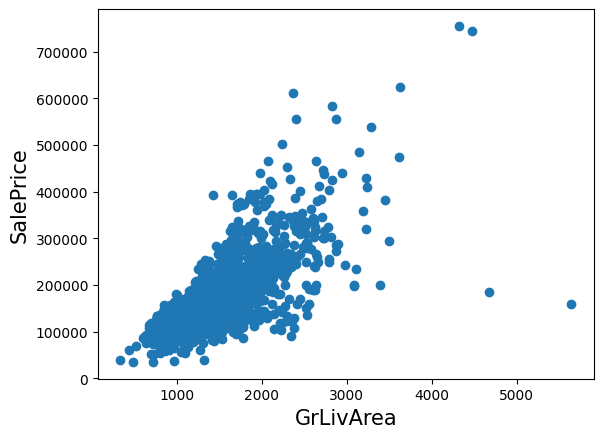

In [ ]:
# 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [ ]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea']>np.log1p(4000)
cond2 = house_df_ohe['SalePrice']<np.log1p(500000)
outlier_index = house_df_ohe[cond1&cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape:',house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 271)
이상치 삭제 후 house_df_ohe shape: (1458, 271)


In [ ]:
y_target = house_df_ohe['SalePrice']
X_features =house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                   random_state=156)

ridge_params={'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params={'alpha':[0.001,0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


### 회귀 트리 모델 학습/예측/평가

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1182, 최적 alpha:{'n_estimators': 1000}


In [ ]:
from lightgbm import LGBMRegressor

lgbm_params={'n_esimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Unknown parameter: n_esimators
[LightGBM] [Warning] Unknown parameter: n_esimators
[LightGBM] [Warning] Unknown parameter: n_esimators
[LightGBM] [Warning] Unknown parameter: n_esimators
[LightGBM] [Warning] Unknown parameter: n_esimators
[LightGBM] [Warning] Unknown parameter: n_esimators
LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1163, 최적 alpha:{'n_esimators': 1000}


### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [ ]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))


# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6*lasso_pred
preds = {'최종 혼합':pred,
        'Ridge':ridge_pred,
        'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 추력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10007930884470506
Ridge 모델의 RMSE: 0.1034517754660323
Lasso 모델의 RMSE: 0.10024170460890035


In [ ]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                        subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5*xgb_pred + 0.5*lgbm_pred
preds = {'최종 혼합':pred,
        'XGBM': xgb_pred,
        'LGBM': lgbm_pred}

get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10129327758047968
XGBM 모델의 RMSE: 0.10617576258589495
LGBM 모델의 RMSE: 0.10382510019327311


### 스태킹 앙상블 모델을 통한 회귀 예측

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stackig_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__,'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter]=model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터 
    return train_fold_pred, test_pred_mean

In [ ]:
# get_stackig_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stackig_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stackig_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stackig_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stackig_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor model 시작
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [ ]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train),axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test),axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09751138566662847
